In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

from sklearn import set_config
set_config(transform_output = 'pandas')
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [2]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes


In [3]:
df=pd.read_csv("Data/train.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [6]:
target=('SalePrice')
y=df[target]
X=df.drop(columns=[target])
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1023,1024,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,14.0,Gd,TA,PConc,Gd,Gd,No,GLQ,16,Unf,0,1330,1346,GasA,Ex,Y,SBrkr,1504,0,0,1504,0,0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2005.0,Fin,2,437,TA,TA,Y,156,20,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal
810,811,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663,LwQ,377,0,1040,GasA,Fa,Y,SBrkr,1309,0,0,1309,1,0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2,484,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal
1384,1385,50,RL,60.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,6,5,1939,1950,Gable,CompShg,WdShing,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,Mn,Rec,204,Unf,0,356,560,GasA,TA,Y,SBrkr,698,560,0,1258,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1939.0,Unf,1,280,TA,TA,P,0,0,0,0,0,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal
626,627,20,RL,NaN,12342,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1960,1978,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,978,978,GasA,TA,Y,SBrkr,1422,0,0,1422,0,0,1,0,3,1,TA,6,Min1,1,TA,Attchd,1960.0,RFn,1,286,TA,TA,Y,0,0,36,0,0,0,NaN,GdWo,Shed,600,8,2007,WD,Normal
813,814,20,RL,75.0,9750,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Gable,CompShg,MetalSd,MetalSd,BrkFace,243.0,TA,TA,CBlock,TA,TA,No,Rec,608,Unf,0,834,1442,GasA,Gd,Y,SBrkr,1442,0,0,1442,0,0,1,1,4,1,TA,7,Typ,0,NaN,Attchd,1958.0,RFn,1,301,TA,TA,Y,0,0,275,0,0,0,NaN,NaN,Shed,500,4,2007,COD,Normal


In [7]:
num_cols = X_train.select_dtypes('number').columns
print('Numeric Columns:', num_cols)

impute_median = SimpleImputer(strategy = 'median')
mmscaler = MinMaxScaler()

num_pipe = make_pipeline(impute_median,mmscaler)
num_tuple = ('Numeric', num_pipe,num_cols)

num_tuple

Numeric Columns: Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')


('Numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('minmaxscaler', MinMaxScaler())]),
 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
        'MiscVal', 'MoSold', 'YrSold'],
       dtype='object'))

In [8]:
ex_list = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
print("Ex list/Columns:", ex_list)

impute_na = SimpleImputer(strategy = 'constant', fill_value='NA')

ex_cond_order = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

ex_category_order = [ex_cond_order, ex_cond_order, ex_cond_order, ex_cond_order, ex_cond_order, 
                     ex_cond_order, ex_cond_order, ex_cond_order, ex_cond_order, ex_cond_order]

ex_encoder = OrdinalEncoder(categories = ex_category_order)

ex_pipe = make_pipeline(impute_na,ex_encoder,mmscaler)
ex_tuple = ("Ex columns", ex_pipe,ex_list)

ex_tuple

Ex list/Columns: ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']


('Ex columns',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd',
                                              'Ex'],
                                             ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                              'Ex'],
                                             ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                              'Ex'],
                                             ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                              'Ex'],
                                             ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                              'Ex'],
                                             ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                              'Ex'],
                                             ['NA', 'Po', 'Fa', 'TA'

In [9]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1023,1024,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,14.0,Gd,TA,PConc,Gd,Gd,No,GLQ,16,Unf,0,1330,1346,GasA,Ex,Y,SBrkr,1504,0,0,1504,0,0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2005.0,Fin,2,437,TA,TA,Y,156,20,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal
810,811,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663,LwQ,377,0,1040,GasA,Fa,Y,SBrkr,1309,0,0,1309,1,0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2,484,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal
1384,1385,50,RL,60.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,6,5,1939,1950,Gable,CompShg,WdShing,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,Mn,Rec,204,Unf,0,356,560,GasA,TA,Y,SBrkr,698,560,0,1258,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1939.0,Unf,1,280,TA,TA,P,0,0,0,0,0,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal
626,627,20,RL,NaN,12342,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1960,1978,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,978,978,GasA,TA,Y,SBrkr,1422,0,0,1422,0,0,1,0,3,1,TA,6,Min1,1,TA,Attchd,1960.0,RFn,1,286,TA,TA,Y,0,0,36,0,0,0,NaN,GdWo,Shed,600,8,2007,WD,Normal
813,814,20,RL,75.0,9750,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Gable,CompShg,MetalSd,MetalSd,BrkFace,243.0,TA,TA,CBlock,TA,TA,No,Rec,608,Unf,0,834,1442,GasA,Gd,Y,SBrkr,1442,0,0,1442,0,0,1,1,4,1,TA,7,Typ,0,NaN,Attchd,1958.0,RFn,1,301,TA,TA,Y,0,0,275,0,0,0,NaN,NaN,Shed,500,4,2007,COD,Normal


In [10]:
ord_cols = ['BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'GarageFinish', 'PavedDrive', 'Fence', 'Functional']
print('Ordinal Columns:',ord_cols)

bsmt_order = ["NA", 'Unf','LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
bsmt_exp_order = ['NA', 'No', 'Mn', 'Av', 'Gd']
gf_order = ['NA', 'Unf', 'RFn', 'Fin']
pd_order = ['N', 'P', 'Y']
f_order = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
func_order = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']

ord_catogory_order = [bsmt_order, bsmt_order, bsmt_exp_order, gf_order, pd_order, f_order, func_order]

ord_encoder = OrdinalEncoder(categories=ord_catogory_order)

ord_pipe = make_pipeline(impute_na, ord_encoder, mmscaler)
ord_tuple = ("Ordinal", ord_pipe,ord_cols)
ord_tuple

Ordinal Columns: ['BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'GarageFinish', 'PavedDrive', 'Fence', 'Functional']


('Ordinal',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['NA', 'Unf', 'LwQ', 'Rec', 'BLQ',
                                              'ALQ', 'GLQ'],
                                             ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ',
                                              'ALQ', 'GLQ'],
                                             ['NA', 'No', 'Mn', 'Av', 'Gd'],
                                             ['NA', 'Unf', 'RFn', 'Fin'],
                                             ['N', 'P', 'Y'],
                                             ['NA', 'MnWw', 'GdWo', 'MnPrv',
                                              'GdPrv'],
                                             ['Sal', 'Sev', 'Maj2', 'Maj1',
                                              'Mod', 'Min2', 'Min1', 'Typ']])),
                 ('minmaxscaler', MinMaxScaler())]),
 ['BsmtF

In [11]:
df['Electrical'].value_counts(dropna=False)

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

In [12]:
df['Electrical'].replace(np.nan,'SBrkr', inplace=True)
df['Electrical'].value_counts(dropna=False)

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [13]:
ohe_cols=X_train.select_dtypes('object').drop(columns=ex_list+ord_cols).columns
print('OneHotEncoder Columns', ohe_cols)

impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_tuple = ("Onehotencoder", ohe_pipe, ohe_cols)
ohe_tuple

OneHotEncoder Columns Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
       'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')


('Onehotencoder',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
        'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'],
       dtype='object'))

In [14]:
col_transformer = ColumnTransformer([num_tuple, ex_tuple, ord_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)

col_transformer

ColumnTransformer(transformers=[('Numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF',...
                                 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
       'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [15]:
X_train_tf = col_transformer.fit_transform(X_train)
X_test_tf = col_transformer.transform(X_test)
X_train_tf.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,BsmtFinType1,BsmtFinType2,BsmtExposure,...,MasVnrType_BrkFace,MasVnrType_NA,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_NA,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1023,0.701165,0.588235,0.075342,0.008797,0.666667,0.500,0.963768,0.933333,0.010160,0.002835,0.000000,0.569349,0.220295,0.268472,0.000000,0.0,0.220422,0.000000,0.0,0.666667,0.0,0.250,0.333333,0.416667,0.333333,0.954545,0.50,0.308181,0.182030,0.036563,0.000000,0.0,0.0,0.000000,0.000000,0.363636,0.50,0.666667,0.5,0.8,1.00,1.00,0.666667,0.8,0.6,0.6,0.0,1.000000,0.166667,0.25,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
810,0.555175,0.000000,0.195205,0.041319,0.555556,0.625,0.739130,0.816667,0.071843,0.117470,0.334516,0.000000,0.170213,0.223726,0.000000,0.0,0.183685,0.333333,0.0,0.333333,0.5,0.375,0.333333,0.250000,0.333333,0.672727,0.50,0.341326,0.309218,0.000000,0.000000,0.0,0.0,0.878049,0.000000,0.000000,0.00,0.333333,0.5,0.6,0.75,0.25,0.666667,0.4,0.6,0.6,0.4,0.833333,0.333333,0.25,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1384,0.948595,0.176471,0.133562,0.036271,0.555556,0.500,0.485507,0.000000,0.000000,0.036145,0.000000,0.152397,0.091653,0.083525,0.271186,0.0,0.174077,0.000000,0.0,0.333333,0.0,0.250,0.333333,0.333333,0.000000,0.354545,0.25,0.197461,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.818182,0.75,0.333333,0.5,0.6,0.75,0.50,0.333333,0.0,0.6,0.6,0.0,0.500000,0.166667,0.50,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
626,0.429061,0.000000,0.167808,0.051611,0.444444,0.500,0.637681,0.466667,0.000000,0.000000,0.000000,0.418664,0.160065,0.249656,0.000000,0.0,0.204974,0.000000,0.0,0.333333,0.0,0.375,0.333333,0.333333,0.333333,0.545455,0.25,0.201693,0.000000,0.000000,0.065217,0.0,0.0,0.000000,0.072289,0.636364,0.25,0.333333,0.5,0.6,0.75,0.50,0.333333,0.6,0.6,0.6,0.0,0.166667,0.166667,0.25,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
813,0.557231,0.000000,0.184932,0.039496,0.555556,0.625,0.623188,0.133333,0.176343,0.107725,0.000000,0.357021,0.236007,0.254245,0.000000,0.0,0.208742,0.000000,0.0,0.333333,0.5,0.500,0.333333,0.416667,0.000000,0.527273,0.25,0.212271,0.000000,0.000000,0.498188,0.0,0.0,0.000000,0.060241,0.272727,0.25,0.333333,0.5,0.6,0.75,0.75,0.333333,0.

In [16]:
input_shape = X_train_tf.shape[1]
input_shape

230

In [17]:
def build_model():
    model = Sequential()
    model.add(Dense(1000, input_dim = input_shape, activation = 'relu'))
    model.add(Dense(750, activation = 'relu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))

    model.compile(loss = 'mse', optimizer = 'adam', 
                  metrics = [metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model

In [18]:
reg_model = build_model()
reg_model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              231000    
                                                                 
 dense_1 (Dense)             (None, 750)               750750    
                                                                 
 dense_2 (Dense)             (None, 500)               375500    
                                                                 
 dense_3 (Dense)             (None, 1)                 501       
                                                                 
Total params: 1,357,751
Trainable params: 1,357,751
Non-trainable params: 0
_________________________________________________________________


In [19]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=3)

In [20]:
history = reg_model.fit(X_train_tf, y_train,validation_split = .2,
                       epochs = 100, verbose = 0, callbacks = [early_stop])

2024-01-08 15:12:46.908291: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


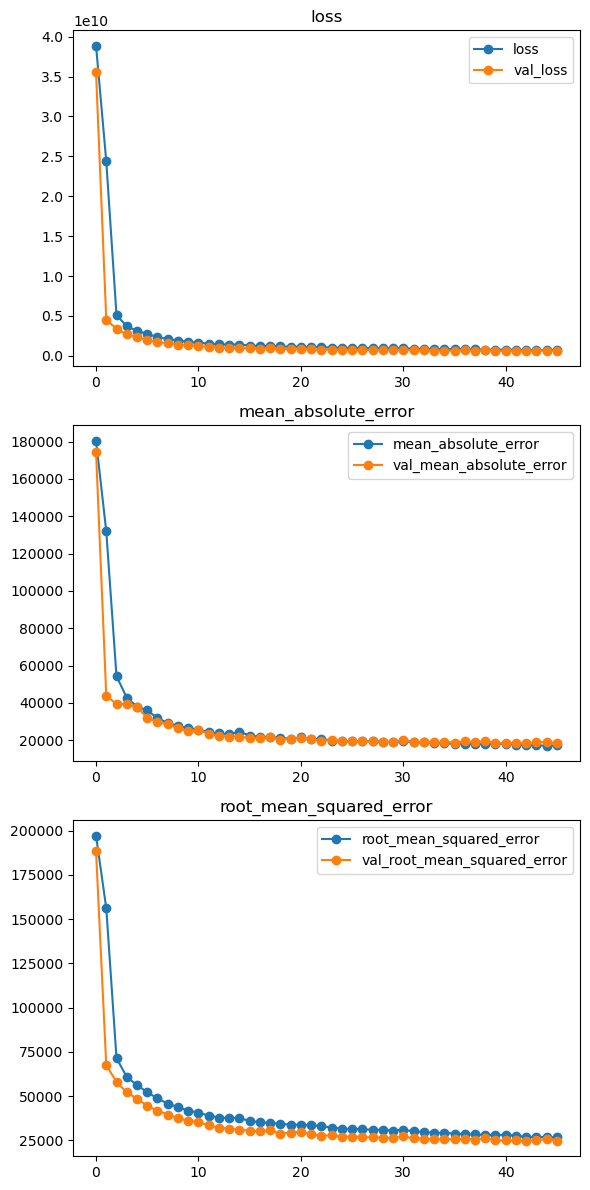

In [21]:
plot_history(history);

In [22]:
y_pred = reg_model.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')


12/12 [==============================] - 0s 4ms/step
final RMSE: 31016.900956472204
final MAE: 19722.972784674657
final R2: 0.8626687077249868


In [23]:
def build_model1():
    model = Sequential()
    model.add(Dense(1000, input_dim = input_shape, activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(750, activation = 'relu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))

    model.compile(loss = 'mse', optimizer = 'adam', 
                  metrics = [metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model

In [24]:
reg_model1 = build_model1()
reg_model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              231000    
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_5 (Dense)             (None, 750)               750750    
                                                                 
 dense_6 (Dense)             (None, 500)               375500    
                                                                 
 dense_7 (Dense)             (None, 1)                 501       
                                                                 
Total params: 1,357,751
Trainable params: 1,357,751
Non-trainable params: 0
_________________________________________________________________


In [25]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=3)

In [26]:
history1 = reg_model1.fit(X_train_tf, y_train,validation_split = .2,
                       epochs = 100, verbose = 0, callbacks = [early_stop])

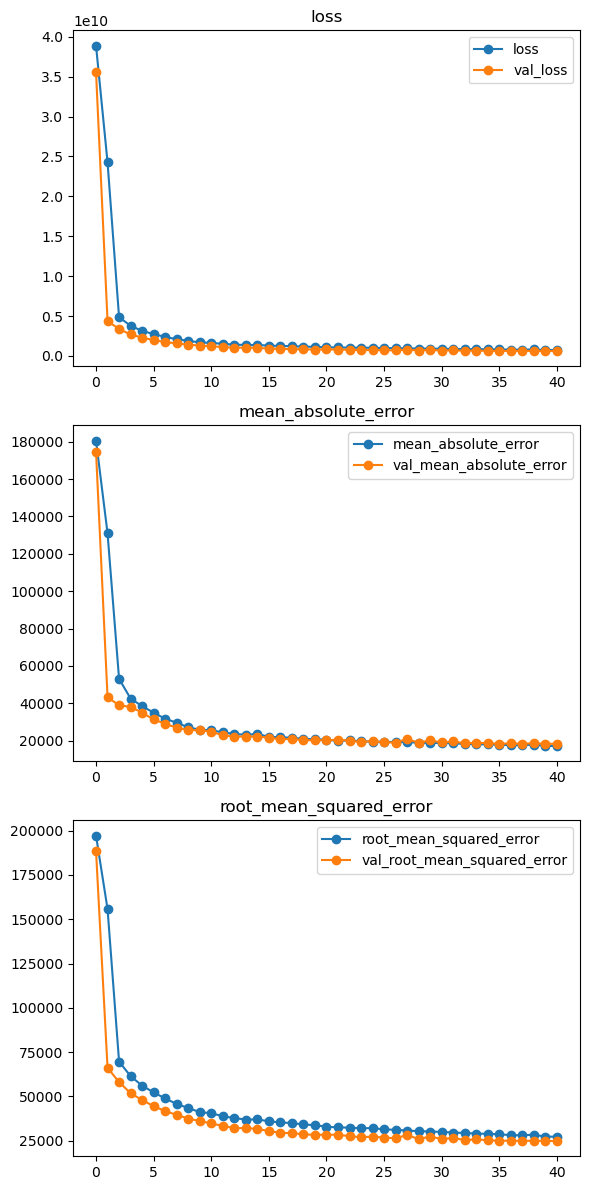

In [27]:
plot_history(history1);

In [28]:
y_pred = reg_model1.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

12/12 [==============================] - 0s 3ms/step
final RMSE: 31340.97729259318
final MAE: 19512.239683219177
final R2: 0.8597839366805907


In [29]:
def build_model2():
    model = Sequential()
    model.add(Dense(1000, input_dim = input_shape, activation = 'relu'))
    model.add(Dense(750, activation = 'relu'))
    model.add(Dense(750, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))

    model.compile(loss = 'mse', optimizer = 'adam', 
                  metrics = [metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model

In [30]:
reg_model2 = build_model2()
reg_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000)              231000    
                                                                 
 dense_9 (Dense)             (None, 750)               750750    
                                                                 
 dense_10 (Dense)            (None, 750)               563250    
                                                                 
 dense_11 (Dense)            (None, 1)                 751       
                                                                 
Total params: 1,545,751
Trainable params: 1,545,751
Non-trainable params: 0
_________________________________________________________________


In [31]:
history2 = reg_model2.fit(X_train_tf, y_train,validation_split = .2,
                       epochs = 100, verbose = 0, callbacks = [early_stop])

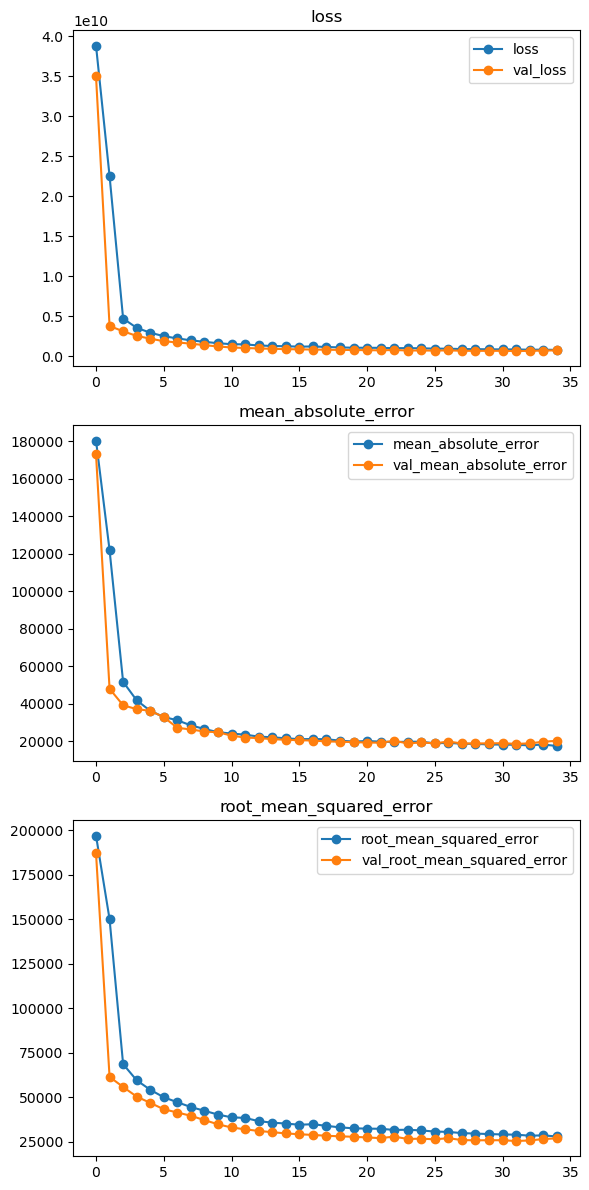

In [32]:
plot_history(history2);

In [33]:
y_pred = reg_model2.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

12/12 [==============================] - 0s 4ms/step
final RMSE: 32881.81415216631
final MAE: 21530.742219606163
final R2: 0.8456579582914263


# First model was the best.  
- Three hidden layers
   - 1000, 750, 500
- Early Stopping

In [34]:
y_pred

array([[148579.08 ],
       [327969.38 ],
       [110073.5  ],
       [174173.22 ],
       [325456.75 ],
       [ 66705.305],
       [232354.67 ],
       [156037.47 ],
       [ 64103.64 ],
       [143317.27 ],
       [149020.77 ],
       [119790.91 ],
       [121403.336],
       [238895.66 ],
       [178808.22 ],
       [140497.4  ],
       [201377.67 ],
       [128937.22 ],
       [136895.55 ],
       [220592.1  ],
       [165987.38 ],
       [205258.64 ],
       [199647.61 ],
       [139746.25 ],
       [212880.31 ],
       [157782.42 ],
       [207316.44 ],
       [109802.74 ],
       [178630.42 ],
       [202079.   ],
       [157353.25 ],
       [319507.7  ],
       [217508.45 ],
       [115680.336],
       [272228.66 ],
       [152295.03 ],
       [148611.66 ],
       [226253.19 ],
       [321419.2  ],
       [115051.12 ],
       [163864.3  ],
       [240631.53 ],
       [112475.16 ],
       [353600.5  ],
       [140264.62 ],
       [141821.27 ],
       [112797.46 ],
       [13250

In [35]:
y_test

892     154500
1105    325000
413     115000
522     159000
1036    315500
         ...  
988     195000
243     120000
1342    228500
1057    248000
1418    124000
Name: SalePrice, Length: 365, dtype: int64

In [40]:
output = pd.DataFrame({'Id':X_test.Id,
                      'SalePrice': y_pred})

output.head()
#output = pd.DataFrame({'Id': test_processed.Id,
                       #'SalePrice': test_preds})

ValueError: Per-column arrays must each be 1-dimensional

In [38]:
X_test_tf.head()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,BsmtFinType1,BsmtFinType2,BsmtExposure,...,MasVnrType_BrkFace,MasVnrType_NA,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_NA,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
892,0.611378,0.000000,0.167808,0.033252,0.555556,0.875,0.659420,0.883333,0.000000,0.117470,0.0,0.169521,0.173322,0.168426,0.000000,0.0,0.138282,0.000000,0.5,0.333333,0.0,0.375,0.333333,0.333333,0.000000,0.572727,0.25,0.186178,0.224037,0.000000,0.000000,0.0,0.0,0.0,0.0,0.090909,0.00,0.333333,0.50,0.6,0.75,0.50,0.333333,0.0,0.6,0.6,0.0,1.000000,0.166667,0.25,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1105,0.757368,0.235294,0.263699,0.051209,0.777778,0.500,0.884058,0.750000,0.262700,0.182849,0.0,0.184503,0.239444,0.267554,0.543341,0.0,0.431047,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.583333,0.666667,0.854545,0.50,0.502116,0.217036,0.058501,0.000000,0.0,0.0,0.0,0.0,0.272727,1.00,0.666667,0.50,1.0,0.75,1.00,0.666667,0.6,0.6,0.6,0.0,1.000000,0.166667,0.75,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
413,0.283071,0.058824,0.119863,0.035804,0.444444,0.625,0.398551,0.000000,0.000000,0.000000,0.0,0.431507,0.164975,0.159247,0.000000,0.0,0.130746,0.000000,0.0,0.333333,0.0,0.250,0.333333,0.250000,0.333333,0.245455,0.50,0.253879,0.000000,0.000000,0.235507,0.0,0.0,0.0,0.0,0.181818,1.00,0.333333,0.50,0.6,0.75,0.75,0.333333,0.8,0.6,0.6,0.0,0.166667,0.166667,0.25,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
522,0.357779,0.176471,0.099315,0.017294,0.555556,0.750,0.543478,0.000000,0.000000,0.070695,0.0,0.258990,0.164321,0.153740,0.319613,0.0,0.250565,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.416667,0.666667,0.454545,0.50,0.296192,0.000000,0.043876,0.065217,0.0,0.0,0.0,0.0,0.818182,0.00,0.333333,0.75,0.6,0.75,1.00,0.333333,0.8,0.6,0.6,0.0,0.833333,0.166667,0.25,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1036,0.710075,0.000000,0.232877,0.054210,0.888889,0.500,0.978261,0.966667,0.050798,0.181077,0.0,0.255993,0.265139,0.295089,0.000000,0.0,0.242276,0.333333,0.0,0.666667,0.0,0.250,0.333333,0.333333,0.333333,0.981818,0.75,0.643159,0.266044,0.000000,0.000000,0.0,0.0,0.0,0.0,0.727273,0.75,0.666667,0.50,1.0,0.75,1.00,1.000000,1.0,0.6,0.6,0.0,1.000000,0.166667,1.00,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0

In [43]:
X_test.Id.shape

(365,)

In [44]:
y_pred.shape

(365, 1)

In [48]:
y_pred.dtype

dtype('float32')

In [52]:
pred = y_pred.flatten()
pred.shape

(365,)

In [53]:
output = pd.DataFrame({'Id': X_test.Id,
                      'SalePrice': pred})
output.head()

,Id,SalePrice
892,893,148579.078125
1105,1106,327969.375000
413,414,110073.500000
522,523,174173.218750
1036,1037,325456.750000


In [56]:
output.to_csv('Data/submission.csv', index=False)
#output.to_csv('submission.csv', index=False)